In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
# Define transforms for training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/train', transform=transform)
val_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
vgg16 = models.vgg16(weights=True)

for param in vgg16.parameters():
   param.requires_grad = False

num_classes = len(train_dataset.classes)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg16 = vgg16.to(device)

C:\Users\cnky2\anaconda3\envs\manu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [4]:
trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of trainable parameters: 12291


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.0001, weight_decay=0.001)

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Training phase
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_bar = tqdm(train_loader, desc="Training")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_bar.set_postfix(loss=running_loss / total_train, accuracy=train_accuracy)

    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation phase
    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_accuracy = 100 * correct_val / total_val
            val_bar.set_postfix(loss=val_loss / total_val, accuracy=val_accuracy)

    # Calculate average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {avg_train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {avg_val_accuracy:.2f}%")

Epoch [1/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:40<00:00,  3.11it/s, accuracy=62.9, loss=0.0271]


Epoch [1/30] - Train Loss: 0.8673, Train Accuracy: 62.86%, Val Loss: 0.7783, Val Accuracy: 69.24%
Epoch [2/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.19it/s, accuracy=77.1, loss=0.0198]


Epoch [2/30] - Train Loss: 0.6335, Train Accuracy: 77.09%, Val Loss: 0.6642, Val Accuracy: 73.91%
Epoch [3/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.19it/s, accuracy=80.4, loss=0.0169]


Epoch [3/30] - Train Loss: 0.5413, Train Accuracy: 80.38%, Val Loss: 0.5920, Val Accuracy: 76.81%
Epoch [4/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.18it/s, accuracy=82.3, loss=0.0153]


Epoch [4/30] - Train Loss: 0.4883, Train Accuracy: 82.25%, Val Loss: 0.5411, Val Accuracy: 78.26%
Epoch [5/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:40<00:00,  3.16it/s, accuracy=83.6, loss=0.0139]


Epoch [5/30] - Train Loss: 0.4449, Train Accuracy: 83.63%, Val Loss: 0.5015, Val Accuracy: 80.52%
Epoch [6/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.18it/s, accuracy=85.5, loss=0.0129]


Epoch [6/30] - Train Loss: 0.4141, Train Accuracy: 85.53%, Val Loss: 0.4717, Val Accuracy: 79.87%
Epoch [7/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.19it/s, accuracy=85.5, loss=0.0124]


Epoch [7/30] - Train Loss: 0.3981, Train Accuracy: 85.48%, Val Loss: 0.4438, Val Accuracy: 84.06%
Epoch [8/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:40<00:00,  3.17it/s, accuracy=86.8, loss=0.0117]


Epoch [8/30] - Train Loss: 0.3728, Train Accuracy: 86.76%, Val Loss: 0.4289, Val Accuracy: 84.54%
Epoch [9/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.21it/s, accuracy=88.4, loss=0.0111]


Epoch [9/30] - Train Loss: 0.3544, Train Accuracy: 88.36%, Val Loss: 0.4102, Val Accuracy: 84.86%
Epoch [10/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.21it/s, accuracy=88.5, loss=0.0107]


Epoch [10/30] - Train Loss: 0.3436, Train Accuracy: 88.46%, Val Loss: 0.3869, Val Accuracy: 86.15%
Epoch [11/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:40<00:00,  3.16it/s, accuracy=88.9, loss=0.0105]


Epoch [11/30] - Train Loss: 0.3360, Train Accuracy: 88.95%, Val Loss: 0.3775, Val Accuracy: 86.31%
Epoch [12/30]


Training: 100%|████████████████████████████████████████████| 127/127 [00:39<00:00,  3.18it/s, accuracy=88.7, loss=0.01]


Epoch [12/30] - Train Loss: 0.3215, Train Accuracy: 88.65%, Val Loss: 0.3639, Val Accuracy: 86.80%
Epoch [13/30]


Training: 100%|███████████████████████████████████████████| 127/127 [00:39<00:00,  3.18it/s, accuracy=90, loss=0.00939]


Epoch [13/30] - Train Loss: 0.3004, Train Accuracy: 90.01%, Val Loss: 0.3488, Val Accuracy: 87.28%
Epoch [14/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:40<00:00,  3.17it/s, accuracy=89.9, loss=0.00932]


Epoch [14/30] - Train Loss: 0.2982, Train Accuracy: 89.88%, Val Loss: 0.3368, Val Accuracy: 88.24%
Epoch [15/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:40<00:00,  3.17it/s, accuracy=90.2, loss=0.00904]


Epoch [15/30] - Train Loss: 0.2892, Train Accuracy: 90.16%, Val Loss: 0.3315, Val Accuracy: 88.41%
Epoch [16/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:40<00:00,  3.16it/s, accuracy=90.5, loss=0.00894]


Epoch [16/30] - Train Loss: 0.2861, Train Accuracy: 90.45%, Val Loss: 0.3179, Val Accuracy: 89.21%
Epoch [17/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:40<00:00,  3.16it/s, accuracy=90.3, loss=0.00857]


Epoch [17/30] - Train Loss: 0.2740, Train Accuracy: 90.33%, Val Loss: 0.3068, Val Accuracy: 89.86%
Epoch [18/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:40<00:00,  3.17it/s, accuracy=91.4, loss=0.00835]


Epoch [18/30] - Train Loss: 0.2670, Train Accuracy: 91.36%, Val Loss: 0.3020, Val Accuracy: 90.02%
Epoch [19/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:40<00:00,  3.15it/s, accuracy=91.5, loss=0.00829]


Epoch [19/30] - Train Loss: 0.2652, Train Accuracy: 91.46%, Val Loss: 0.2903, Val Accuracy: 90.18%
Epoch [20/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.18it/s, accuracy=91.4, loss=0.0081]


Epoch [20/30] - Train Loss: 0.2593, Train Accuracy: 91.39%, Val Loss: 0.2868, Val Accuracy: 89.86%
Epoch [21/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:39<00:00,  3.20it/s, accuracy=91.5, loss=0.00786]


Epoch [21/30] - Train Loss: 0.2515, Train Accuracy: 91.53%, Val Loss: 0.2835, Val Accuracy: 90.18%
Epoch [22/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:40<00:00,  3.14it/s, accuracy=91.7, loss=0.00791]


Epoch [22/30] - Train Loss: 0.2531, Train Accuracy: 91.73%, Val Loss: 0.2706, Val Accuracy: 91.30%
Epoch [23/30]


Training: 100%|███████████████████████████████████████████| 127/127 [00:39<00:00,  3.19it/s, accuracy=92, loss=0.00763]


Epoch [23/30] - Train Loss: 0.2441, Train Accuracy: 91.98%, Val Loss: 0.2667, Val Accuracy: 91.30%
Epoch [24/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:39<00:00,  3.18it/s, accuracy=92.3, loss=0.00763]


Epoch [24/30] - Train Loss: 0.2441, Train Accuracy: 92.32%, Val Loss: 0.2598, Val Accuracy: 91.79%
Epoch [25/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:39<00:00,  3.19it/s, accuracy=91.8, loss=0.00743]


Epoch [25/30] - Train Loss: 0.2378, Train Accuracy: 91.78%, Val Loss: 0.2553, Val Accuracy: 90.82%
Epoch [26/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:40<00:00,  3.15it/s, accuracy=92.6, loss=0.0073]


Epoch [26/30] - Train Loss: 0.2335, Train Accuracy: 92.59%, Val Loss: 0.2508, Val Accuracy: 90.82%
Epoch [27/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:39<00:00,  3.20it/s, accuracy=92.2, loss=0.00731]


Epoch [27/30] - Train Loss: 0.2339, Train Accuracy: 92.17%, Val Loss: 0.2461, Val Accuracy: 91.95%
Epoch [28/30]


Training: 100%|█████████████████████████████████████████| 127/127 [00:39<00:00,  3.20it/s, accuracy=92.5, loss=0.00708]


Epoch [28/30] - Train Loss: 0.2264, Train Accuracy: 92.52%, Val Loss: 0.2389, Val Accuracy: 92.11%
Epoch [29/30]


Training: 100%|███████████████████████████████████████████| 127/127 [00:40<00:00,  3.16it/s, accuracy=92.8, loss=0.007]


Epoch [29/30] - Train Loss: 0.2239, Train Accuracy: 92.79%, Val Loss: 0.2365, Val Accuracy: 92.27%
Epoch [30/30]


Training: 100%|██████████████████████████████████████████| 127/127 [00:39<00:00,  3.19it/s, accuracy=93.3, loss=0.0068]
                                                                                                                       

Epoch [30/30] - Train Loss: 0.2176, Train Accuracy: 93.26%, Val Loss: 0.2333, Val Accuracy: 92.43%


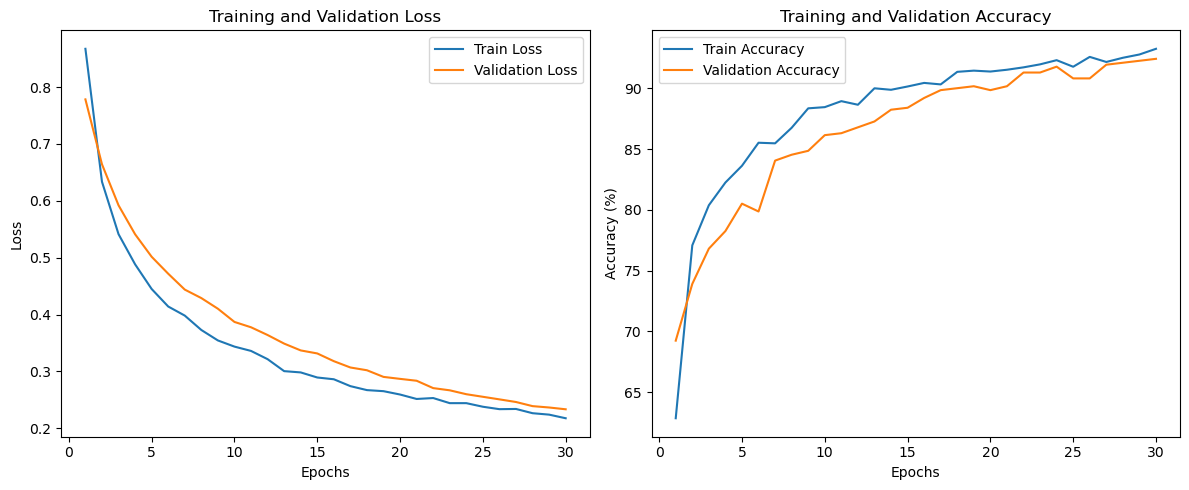

In [7]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()